## Imports

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import os
import sys
import jax
import pandas as pd
import numpy as np
import jax.numpy as jnp
import haiku as hk
import seaborn as sns
import matplotlib.pyplot as plt
from synbio_morpher.utils.data.data_format_tools.manipulate_fasta import load_seq_from_FASTA
from synbio_morpher.utils.evolution.mutation import get_mutation_type_mapping


if __package__ is None:

    module_path = os.path.abspath(os.path.join('..'))
    sys.path.append(module_path)

    __package__ = os.path.basename(module_path)
    

from src.models.nucleotide_transformer import NucleotideTransformerConfig, build_nucleotide_transformer_fn
from src.models.pretrained import FixedSizeNucleotidesKmersTokenizer

root_dir = '..'

# Processing

In [10]:
# rel_fn = 'data/raw/ensemble_mutation_effect_analysis/2023_06_05_164913/tabulated_mutation_info.csv'
rel_fn = 'data/raw/ensemble_mutation_effect_analysis/2023_05_16_174613/tabulated_mutation_info.csv'
fn = os.path.join(root_dir, rel_fn)

In [11]:
data = pd.read_csv(fn)
data.head()

,circuit_name,mutation_name,mutation_num,mutation_type,mutation_positions,path_to_template_circuit,name,interacting,self_interacting,num_interacting,...,RMSE_diff_to_base_circuit,steady_states_diff_to_base_circuit,fold_change_ratio_from_mutation_to_base,initial_steady_states_ratio_from_mutation_to_base,max_amount_ratio_from_mutation_to_base,min_amount_ratio_from_mutation_to_base,overshoot_ratio_from_mutation_to_base,RMSE_ratio_from_mutation_to_base,steady_states_ratio_from_mutation_to_base,sample_name
0,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,inf,1.000000,RNA_0
1,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,inf,inf,1.000000,RNA_1
2,toy_circuit_combo0_100572,ref_circuit,0,[],[],NaN,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,inf,1.000000,RNA_2
3,toy_circuit_combo0_100572,RNA_0_m1-0,1,[3],[13],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.170031,-0.170135,0.999560,1.000000,0.999610,1.000000,1.060197,inf,0.999560,RNA_0
4,toy_circuit_combo0_100572,RNA_0_m1-0,1,[3],[13],data/generate_seqs_flexible/2023_04_17_205800/...,toy_circuit_combo0_100572,[[0 2]\n [1 2]],[[2 2]],2,...,0.005415,0.005417,1.000012,1.000015,1.000027,1.000015,inf,inf,1.000027,RNA_1


Preprocess

In [12]:
def convert_column_to_list_of_int(df_col):
    return df_col.apply(lambda x: [int(i.replace('[', '').replace(']', '')) for i in x.split(',') if i.replace('[', '').replace(']', '').strip().isdigit()])


In [13]:
data['mutation_type'] = convert_column_to_list_of_int(data['mutation_type'])
data['mutation_positions'] = convert_column_to_list_of_int(data['mutation_positions'])

In [14]:
data[data['sample_name'] == 'RNA_1'][['mutation_name', 'mutation_positions', 'mutation_type']]

,mutation_name,mutation_positions,mutation_type
1,ref_circuit,[],[]
4,RNA_0_m1-0,[13],[3]
7,RNA_0_m1-1,[2],[5]
10,RNA_0_m1-2,[8],[6]
13,RNA_0_m1-3,[17],[4]
...,...,...,...
542986,RNA_2_m15-5,"[8, 15, 5, 12, 14, 13, 6, 11, 0, 4, 16, 2, 9, ...","[8, 4, 4, 7, 0, 7, 0, 7, 1, 6, 3, 8, 10, 6, 2]"
542989,RNA_2_m15-6,"[16, 7, 18, 5, 6, 15, 0, 17, 8, 1, 9, 11, 10, ...","[4, 6, 0, 5, 1, 4, 2, 0, 6, 7, 10, 8, 9, 1, 6]"
542992,RNA_2_m15-7,"[2, 6, 7, 3, 18, 15, 0, 1, 16, 12, 14, 11, 8, ...","[8, 2, 6, 10, 0, 4, 1, 8, 4, 8, 1, 7, 6, 9, 8]"
542995,RNA_2_m15-8,"[12, 5, 19, 13, 15, 17, 6, 10, 1, 14, 2, 11, 0...","[6, 4, 3, 8, 5, 1, 0, 11, 6, 0, 8, 8, 0, 4, 8]"


In [15]:
# source_dir = '/home/wadh6511/Kode/gene-circuit-glitch-prediction'
# paths = data['path_to_template_circuit'].unique()
# for p in paths:
#     if type(p) != str:
#         continue
#     fp = os.path.join(source_dir, p)
    
#     p_spl = str(p.split('data/')[-1])
#     dst = os.path.join(root_dir, 'data', 'raw', p_spl)
#     # print(dst)
#     shutil.copyfile(fp, dst)


## Mode 1 - string of RNA

Add the actual sequence pre-mutation to as a field

In [16]:
data['mutation_species'] = data['mutation_name'].str[:5]
# data['src_sequence'] = np.nan


Load RNA sequences.

In [17]:
mutation_species = data['mutation_species'].unique()
circuit_name = data['circuit_name'].unique()
path_to_template_circuit = list(data[data['mutation_num'] > 0]['path_to_template_circuit'].unique())
circuit_paths = jax.tree_util.tree_map(lambda x: os.path.join(root_dir, 'data', 'raw', str(x.split('data/')[-1])), path_to_template_circuit)
fastas = jax.tree_util.tree_map(lambda cp: load_seq_from_FASTA(cp, as_type='dict'), circuit_paths)
fasta_d = dict(zip(circuit_name, fastas))

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/generate_seqs_flexible/2023_04_17_205800/circuits/toy_circuit_combo0_100572.fasta'

In [ ]:
# data['src_sequence'] = jax.tree_util.tree_map(lambda cn, ms, sn: fasta_d[cn][ms] if ms != 'ref_c' else fasta_d[cn][sn], data['circuit_name'].to_list(), data['mutation_species'].to_list(), data['sample_name'].to_list())

Simplify mutation_types

In [ ]:


data['mutation_types_simp'] = data['mutation_type']

mutation_type_mapping = get_mutation_type_mapping('RNA')
mutation_type_mapping_simp = {k: v for k, v in zip(mutation_type_mapping.keys(), np.arange(1, len(mutation_type_mapping)+1))}
mutation_map_translation = {}
for (ka, kb), v in jax.tree_util.tree_flatten_with_path(mutation_type_mapping)[0]:
    mutation_map_translation[v] = mutation_type_mapping_simp[kb.key]

data['mutation_types_simp'] = data['mutation_types_simp'].apply(lambda x: jax.tree_util.tree_map(lambda y: mutation_map_translation[y] if x else [], x))
mutation_map_translation


{0: 2, 1: 3, 2: 4, 3: 1, 4: 3, 5: 4, 6: 1, 7: 2, 8: 4, 9: 1, 10: 2, 11: 3}

In [ ]:
def apply_values(sequence, indices, values):
    # GCG
    result = np.zeros(len(sequence))
    list(map(lambda idx, val: result.__setitem__(idx, val), indices, values))
    return result

sequence = 'ABDSAFD'
indices = (0, 5, 6)
values = (1, 1, 3)

output = apply_values(sequence, indices, values)
output

# Expected output: [1., 0., 0., 0., 0., 1., 3.]

array([1., 0., 0., 0., 0., 1., 3.])

In [ ]:
# data['mutation_types_seq'] = jax.tree_util.tree_map(lambda seq, typs, pos: apply_values(seq, pos, typs) if typs else np.zeros(len(seq)), data['src_sequence'].to_list(), data['mutation_types_simp'].to_list(), data['mutation_positions'].to_list())

### Combine into input

Circuit represented as $n$ RNA sequences

In [ ]:


def reverse_mut_mapping(mut_encoding: int, sequence_type: str = 'RNA'):
    for k, v in get_mutation_type_mapping(sequence_type).items():
        if mut_encoding in list(v.values()):
            for mut, enc in v.items():
                if enc == mut_encoding:
                    return mut
    raise ValueError(
        f'Could not find mutation for mapping key {mut_encoding}.')
    
def apply_values(sequence, indices, values):
    result = np.array(list(sequence))
    list(map(lambda idx, val: result.__setitem__(idx, val), indices, values))
    return ''.join(result)
# data['src_sequence'] = jax.tree_util.tree_map(lambda cn, ms, sn: fasta_d[cn][ms] if ms != 'ref_c' else fasta_d[cn][sn], data['circuit_name'].to_list(), data['mutation_species'].to_list(), data['sample_name'].to_list())

d = {v: v for v in jax.tree_util.tree_flatten(get_mutation_type_mapping('RNA'))[0]}
mutation_type_mapping_rev = jax.tree_util.tree_map(lambda x: reverse_mut_mapping(x), d)



In [ ]:
data['mutation_type_explicit'] = jax.tree_util.tree_map(lambda mt: mutation_type_mapping_rev[mt], data['mutation_type'].to_list())
data['sample_seq'] = jax.tree_util.tree_map(lambda cn, sn, ms, mp, mt: fasta_d[cn][sn] if sn != ms else apply_values(fasta_d[cn][sn], mp, mt), 
                                            *[data[x].to_list() for x in ['circuit_name', 'sample_name', 'mutation_species', 'mutation_positions', 'mutation_type_explicit']])
# data['sample_seq'] = jax.tree_util.tree_map(lambda cn, sn: fasta_d[cn][sn], data['circuit_name'].to_list(), data['sample_name'].to_list())

In [ ]:


# data['sample_seq_mut'] = jax.tree_util.tree_map(
#     lambda ms, sn, seq, mp, mt: apply_values(seq, mp, [mutation_type_mapping_rev[t] for t in mt]) if mp and ms == sn else seq, 
#     *[data[x].to_list() for x in ['mutation_species', 'sample_name', 'sample_seq', 'mutation_positions', 'mutation_type']])


## Labels

For now, we will discretise the labels on a log scale to accommodate sensitivity and precision. 

In [ ]:
data['sensitivity_wrt_species-6_ratio_from_mutation_to_base']

0          1.000000
1          1.000000
2          1.000000
3          1.000000
4          1.000000
             ...   
1085995    0.847782
1085996    0.847782
1085997    1.000000
1085998    1.000000
1085999    1.000000
Name: sensitivity_wrt_species-6_ratio_from_mutation_to_base, Length: 1086000, dtype: float64

In [ ]:
from synbio_morpher.utils.results.analytics.naming import get_true_names_analytics

get_true_names_analytics(data)

['fold_change',
 'initial_steady_states',
 'max_amount',
 'min_amount',
 'overshoot',
 'RMSE',
 'steady_states',
 'response_time_wrt_species-6',
 'response_time_wrt_species-6_diff_to_base_circuit',
 'response_time_wrt_species-6_ratio_from_mutation_to_base',
 'precision_wrt_species-6',
 'precision_wrt_species-6_diff_to_base_circuit',
 'precision_wrt_species-6_ratio_from_mutation_to_base',
 'sensitivity_wrt_species-6',
 'sensitivity_wrt_species-6_diff_to_base_circuit',
 'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
 'fold_change_diff_to_base_circuit',
 'initial_steady_states_diff_to_base_circuit',
 'max_amount_diff_to_base_circuit',
 'min_amount_diff_to_base_circuit',
 'overshoot_diff_to_base_circuit',
 'RMSE_diff_to_base_circuit',
 'steady_states_diff_to_base_circuit',
 'fold_change_ratio_from_mutation_to_base',
 'initial_steady_states_ratio_from_mutation_to_base',
 'max_amount_ratio_from_mutation_to_base',
 'min_amount_ratio_from_mutation_to_base',
 'overshoot_ratio_from_mut

In [ ]:
dirlist = [root_dir, 'data', 'processed'] + fn.split('raw/')[-1].split(os.sep)
for i, d in enumerate(dirlist[:-1]):
    if not os.path.isdir(os.path.join(*dirlist[:i+1])):
        print('Making directory ', os.path.join(*dirlist[:i+1]))
        os.makedirs(os.path.join(*dirlist[:i+1]), mode=0o777)
    
# os.path.join(*dirlist)

In [ ]:
data[['circuit_name', 'mutation_name', 'mutation_species', 'mutation_num', 'sample_seq', 'sample_name'] + [
    # 'fold_change',
    # 'initial_steady_states',
    # 'max_amount',
    # 'min_amount',
    # 'overshoot',
    'RMSE',
    # 'steady_states',
    # 'response_time_wrt_species-6',
    # 'response_time_wrt_species-6_diff_to_base_circuit',
    'response_time_wrt_species-6_ratio_from_mutation_to_base',
    # 'precision_wrt_species-6',
    # 'precision_wrt_species-6_diff_to_base_circuit',
    'precision_wrt_species-6_ratio_from_mutation_to_base',
    # 'sensitivity_wrt_species-6',
    # 'sensitivity_wrt_species-6_diff_to_base_circuit',
    'sensitivity_wrt_species-6_ratio_from_mutation_to_base',
    # 'fold_change_diff_to_base_circuit',
    # 'initial_steady_states_diff_to_base_circuit',
    # 'max_amount_diff_to_base_circuit',
    # 'min_amount_diff_to_base_circuit',
    # 'overshoot_diff_to_base_circuit',
    # 'RMSE_diff_to_base_circuit',
    # 'steady_states_diff_to_base_circuit',
    'fold_change_ratio_from_mutation_to_base',
    'initial_steady_states_ratio_from_mutation_to_base',
    'max_amount_ratio_from_mutation_to_base',
    'min_amount_ratio_from_mutation_to_base',
    'overshoot_ratio_from_mutation_to_base',
    # 'RMSE_ratio_from_mutation_to_base',
    'steady_states_ratio_from_mutation_to_base'
]].to_csv(os.path.join(*dirlist))

# Nucleotide Transformer

In [ ]:


def calculate_max_positions(max_seq_length, k_for_kmers, kmer_overlap):
    # Implement
    return 32

hyperparams = {
    'k_for_kmers': 5,
    'max_positions': 32,
    'embed_scale': 1.0,
    'emb_layer_norm_before': False,
    'key_size': 64,
    'attention_heads': 20,
    'embed_dim': 1280,
    'ffn_embed_dim': 5120,
    'num_layers': 24,
    'token_dropout': True,
    'masking_ratio': 0.15,
    'masking_prob': 0.8,
    'use_gradient_checkpointing': False,
}


tokenizer = FixedSizeNucleotidesKmersTokenizer(
    k_mers=hyperparams["k_for_kmers"],
    fixed_length=32, # calculate_max_positions(max_seq_length, k_for_kmers, kmer_overlap),
    prepend_cls_token=True,
)

embeddings_layers_to_save = tuple(np.arange(hyperparams["num_layers"]))
attention_maps_to_save = ((1, 4, 5), (7, 18))  # t[0] is the layer index, rest is attention map
ncfg = NucleotideTransformerConfig(
    alphabet_size=len(tokenizer.vocabulary) - 2,
    pad_token_id=tokenizer.pad_token_id,
    mask_token_id=tokenizer.mask_token_id,
    max_positions=hyperparams['max_positions'],
    embed_scale=hyperparams["embed_scale"],
    # architecture
    emb_layer_norm_before=hyperparams["emb_layer_norm_before"],
    key_size=hyperparams["key_dim"] if "key_dim" in hyperparams.keys() else None,
    attention_heads=hyperparams["attention_heads"],
    embed_dim=hyperparams["embed_dim"],
    ffn_embed_dim=hyperparams["ffn_embed_dim"],
    num_layers=hyperparams["num_layers"],
    # bert
    token_dropout=hyperparams["token_dropout"],
    masking_ratio=hyperparams["masking_ratio"],
    masking_prob=hyperparams["masking_prob"],
    # embeddings to save
    embeddings_layers_to_save=embeddings_layers_to_save,
    attention_maps_to_save=attention_maps_to_save,
)

t = build_nucleotide_transformer_fn(ncfg)


In [ ]:

x = np.random.randint(1, 10, [4,3])
t_t = hk.transform(t)
rng = jax.random.PRNGKey(0)
params = t_t.init(rng, x)
print(hk.experimental.tabulate(t_t.apply)(x))
dot = hk.experimental.to_dot(t_t.apply)(params, None, x)

import graphviz
# graphviz.Source(dot)

+------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------+-----------------------------------------------+-------------------------------------------------------------------+---------------+---------------+
| Module                                                                             | Config                                                                                                                                                     

In [ ]:
res = t_t.apply(params, None, x)
res.keys()

dict_keys(['embeddings_1', 'attention_map_layer_1_number_4', 'attention_map_layer_1_number_5', 'embeddings_2', 'embeddings_3', 'embeddings_4', 'embeddings_5', 'embeddings_6', 'embeddings_7', 'attention_map_layer_7_number_18', 'embeddings_8', 'embeddings_9', 'embeddings_10', 'embeddings_11', 'embeddings_12', 'embeddings_13', 'embeddings_14', 'embeddings_15', 'embeddings_16', 'embeddings_17', 'embeddings_18', 'embeddings_19', 'embeddings_20', 'embeddings_21', 'embeddings_22', 'embeddings_23', 'logits'])

<Axes: ylabel='Count'>

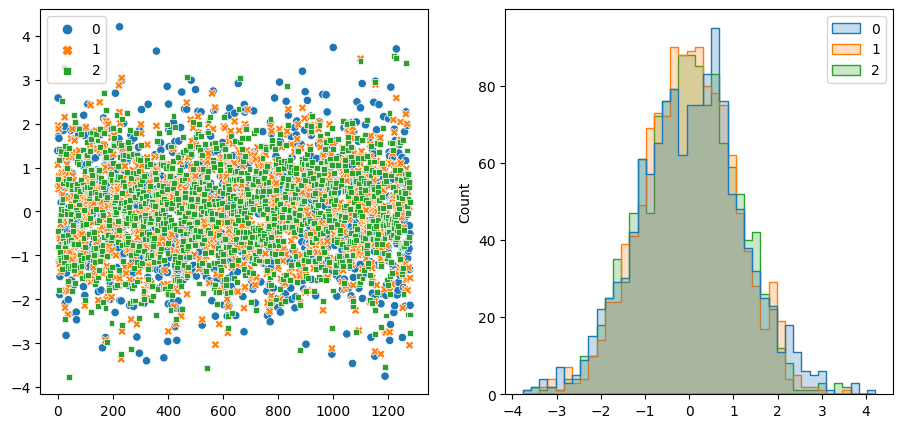

In [ ]:
plt.figure(figsize=(11, 5))
ax = plt.subplot(1,2,1)
sns.scatterplot(jnp.average(res['embeddings_1'], axis=0).T)
ax = plt.subplot(1,2,2)
sns.histplot(jnp.average(res['embeddings_1'], axis=0).T, element='step')
